#**Task 2 of Mini Project: Text Classification using Deep Learning**

##**1. Data Loading**

In [ ]:
!pip install nltk keras gensim scikit-learn

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Description         1615 non-null   object
 1   Predicted_Category  1615 non-null   object
dtypes: object(2)
memory usage: 25.4+ KB
None

Sample data:
                                         Description Predicted_Category
0  TP-Link TL-WA850RE 300Mbps Universal Wi-Fi Ran...        Electronics
1  QuantumZERO External Powered USB 3.0 Hub (10 P...        Electronics
2  Godrej C071 Aluminum Alloy Door Closer Constru...    Office Supplies
3  SanDisk Ultra Dual 16GB USB 3.0 OTG Pen Drive ...        Electronics
4  Netgear WN3000RP-200PES Universal Wi-Fi Range ...        Electronics


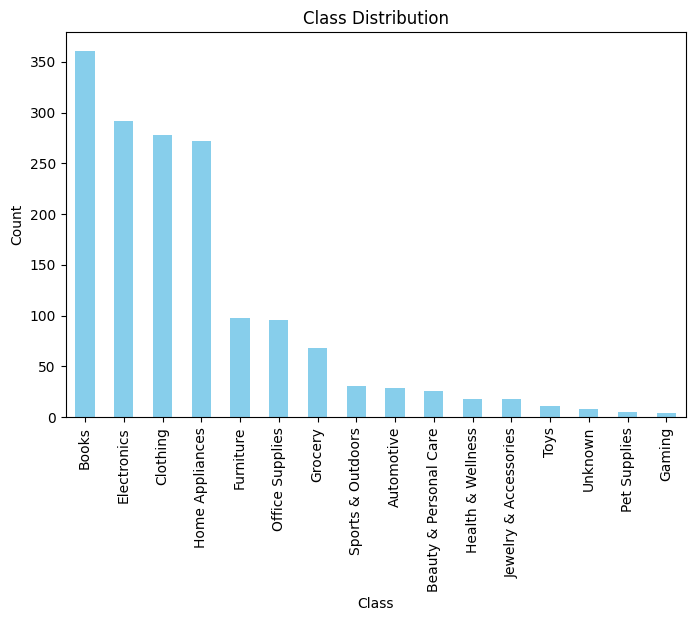

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/final1(1).csv')  # Replace with actual dataset path
0
# Exploratory Data Analysis (EDA)
print("Dataset overview:")
print(data.info())  # Checking for missing values, data types
print("\nSample data:")
print(data.head())  # Display the first few rows

# Plot class distribution
plt.figure(figsize=(8, 5))
data['Predicted_Category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Splitting data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

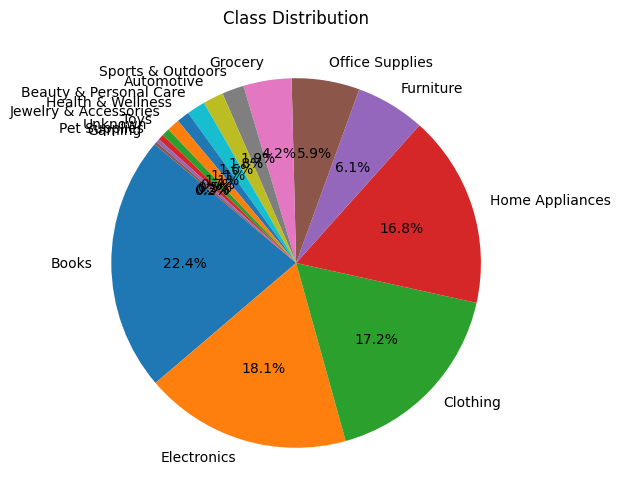

In [ ]:
class_distribution = data['Predicted_Category'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution")
plt.show()

##**2. Text Preprocessing**

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.9 MB/s eta 0:00:00


In [ ]:
import re
import nltk
import pandas as pd
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_description(text):
    # Expand contractions (e.g., "it's" → "it is")
    text = contractions.fix(text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces

    # Tokenization
    words = word_tokenize(text)

    # Remove stopwords and apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]

    return ' '.join(words)

# Apply preprocessing to the 'Product Description' column
train_data['Processed_Description'] = train_data['Description'].apply(preprocess_description)
val_data['Processed_Description'] = val_data['Description'].apply(preprocess_description)
test_data['Processed_Description'] = test_data['Description'].apply(preprocess_description)
# Display cleaned descriptions
print(train_data[['Description', 'Processed_Description']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                            Description  \
87    Cherokee by Unlimited Girls' Regular Fit Skirt...   
1177  Elistooop Bluetooth Speaker Stereo Strong Bass...   
882   Periodontics Revisited About the Author Shalu ...   
52            Textbook Of Prosthodontics (Old Edition)    
423   Nyx Professional Makeup Lip Lingerie Liquid Li...   

                                  Processed_Description  
87    cherokee unlimited girl regular fit skirt cher...  
1177  elistooop bluetooth speaker stereo strong bass...  
882   periodontics revisited author shalu bathla md ...  
52                  textbook prosthodontics old edition  
423   nyx professional makeup lip lingerie liquid li...  


##**3. Text Embedding**

In [ ]:
from huggingface_hub import login
login(token="")

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['Processed_Description']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['Processed_Description']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['Processed_Description']).toarray()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Processed_Description']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['Processed_Description']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['Processed_Description']).toarray()

# Tokenize the descriptions once
train_tokens = train_data['Processed_Description'].apply(str.split)
val_tokens = val_data['Processed_Description'].apply(str.split)
test_tokens = test_data['Processed_Description'].apply(str.split)

# FastText (Word Embeddings)
fasttext_model = gensim.models.FastText(train_tokens, vector_size=100, window=5, min_count=5)

X_train_fasttext = np.array([np.mean([fasttext_model.wv[word] for word in tokens if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for tokens in train_tokens])
X_val_fasttext = np.array([np.mean([fasttext_model.wv[word] for word in tokens if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for tokens in val_tokens])
X_test_fasttext = np.array([np.mean([fasttext_model.wv[word] for word in tokens if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for tokens in test_tokens])

# Word2Vec (Custom Trained)
word2vec_model = gensim.models.Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=5)

X_train_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for tokens in train_tokens])
X_val_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for tokens in val_tokens])
X_test_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for tokens in test_tokens])

# BERT Embeddings
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    tokens = bert_tokenizer(text, padding='max_length', max_length=50, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = bert_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

X_train_bert = np.array([get_bert_embedding(text) for text in train_data['Processed_Description']])
X_val_bert = np.array([get_bert_embedding(text) for text in val_data['Processed_Description']])
X_test_bert = np.array([get_bert_embedding(text) for text in test_data['Processed_Description']])

print("Embeddings completed for BoW, TF-IDF, FastText, Word2Vec and BERT.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
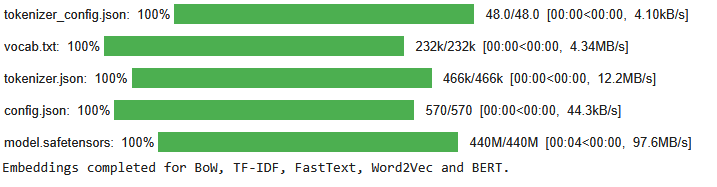

##**4. Model Training with Different Architectures**

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Embedding, Flatten, MultiHeadAttention, LayerNormalization, Add, Input
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

encoder = LabelEncoder()
y_train = encoder.fit_transform(train_data['Predicted_Category'])
y_val = encoder.transform(val_data['Predicted_Category'])
y_test = encoder.transform(test_data['Predicted_Category'])

def cnn_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class
    optimizer = Adam(learning_rate=0.001)  # Lower learning rate if necessary
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def lstm_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn_bilstm_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def transformer_model(input_dim, num_classes):
    # Define input layer
    input_layer = Input(shape=(input_dim,))  # Input dimension (e.g., word2vec, fasttext)

    # Embedding layer (optional if using pre-trained embeddings)
    embedding_layer = Embedding(input_dim=input_dim, output_dim=128)(input_layer)

    # Transformer Encoder Block with LSTM and Multi-Head Attention
    x = LSTM(100, return_sequences=True)(embedding_layer)  # LSTM to process sequences

    # Multi-head attention block
    attention_output = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    attention_output = LayerNormalization()(attention_output)
    x = Add()([x, attention_output])  # Skip connection

    # Flatten and add Dense layers for classification
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer for multi-class classification

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def fully_connected_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

input_dim = 5000
num_classes = 16

input_dim_bow = X_train_bow.shape[1]
input_dim_tfidf = X_train_tfidf.shape[1]
input_dim_fasttext = X_train_fasttext.shape[1]  # For FastText embeddings
input_dim_word2vec = X_train_word2vec.shape[1]  # For Word2Vec embeddings
input_dim_bert = X_train_bert.shape[1]  # For BERT embeddings

# CNN Model
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
cnn = cnn_model(input_dim_word2vec, num_classes)
cnn.fit(X_train_bow, y_train, validation_data=(X_val_bow, y_val), epochs=5, batch_size=64, callbacks=[lr_scheduler])

# LSTM Model
lstm = lstm_model(input_dim, num_classes)
lstm.fit(X_train_bow, y_train, validation_data=(X_val_bow, y_val), epochs=5, batch_size=64)

# CNN-BiLSTM Model
cnn_bilstm = cnn_bilstm_model(input_dim, num_classes)
cnn_bilstm.fit(X_train_bow, y_train, validation_data=(X_val_bow, y_val), epochs=5, batch_size=64)

# Train Transformer model with Word2Vec embeddings
transformer_word2vec = transformer_model(input_dim_word2vec, num_classes)
transformer_word2vec.fit(X_train_word2vec, y_train, validation_data=(X_val_word2vec, y_val), epochs=5, batch_size=64)

# Train Fully Connected model with BERT embeddings
fully_connected_bert = fully_connected_model(input_dim_bert, num_classes)
fully_connected_bert.fit(X_train_bert, y_train, validation_data=(X_val_bert, y_val), epochs=5, batch_size=64)

print("All models trained successfully!")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.1923 - loss: 2.4873 - val_accuracy: 0.5385 - val_loss: 2.0197 - learning_rate: 0.0010
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.6143 - loss: 1.7267 - val_accuracy: 0.6615 - val_loss: 1.1216 - learning_rate: 0.0010
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.8431 - loss: 0.7479 - val_accuracy: 0.6769 - val_loss: 1.4502 - learning_rate: 0.0010
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9477 - loss: 0.2172 - val_accuracy: 0.7462 - val_loss: 0.9572 - learning_rate: 0.0010
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9868 - loss: 0.0702 - val_accuracy: 0.7846 - val_loss: 0.9697 - learning_rate: 0.0010
Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 344s 17s/step - accuracy: 0.1383 - loss: 2.5299 - val_accuracy: 0.1462 - val_loss: 2.0636
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 369s 17s/step - accuracy: 0.1978 - loss: 2.1953 - val_accuracy: 0.1308 - val_loss: 2.0392
Epoch 3/5
1

##**5. Comparative Analysis of Models**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Evaluate CNN Model
y_pred_cnn = cnn.predict(X_test_bow)
cnn_acc = accuracy_score(y_test, y_pred_cnn.argmax(axis=1))
print("CNN Accuracy:", cnn_acc)
print("CNN Classification Report:\n", classification_report(y_test, y_pred_cnn.argmax(axis=1)))

# Evaluate LSTM Model
y_pred_lstm = lstm.predict(X_test_bow)
lstm_acc = accuracy_score(y_test, y_pred_lstm.argmax(axis=1))
print("LSTM Accuracy:", lstm_acc)
print("LSTM Classification Report:\n", classification_report(y_test, y_pred_lstm.argmax(axis=1)))

# Evaluate CNN-BiLSTM Model
y_pred_cnn_bilstm = cnn_bilstm.predict(X_test_bow)
cnn_bilstm_acc = accuracy_score(y_test, y_pred_cnn_bilstm.argmax(axis=1))
print("CNN-BiLSTM Accuracy:", cnn_bilstm_acc)
print("CNN-BiLSTM Classification Report:\n", classification_report(y_test, y_pred_cnn_bilstm.argmax(axis=1)))

# Evaluate Transformer (Word2Vec) Model
y_pred_transformer = transformer_word2vec.predict(X_test_word2vec)
transformer_acc = accuracy_score(y_test, y_pred_transformer.argmax(axis=1))
print("Transformer (Word2Vec) Accuracy:", transformer_acc)
print("Transformer (Word2Vec) Classification Report:\n", classification_report(y_test, y_pred_transformer.argmax(axis=1)))

# Evaluate Fully Connected (BERT) Model
y_pred_fc_bert = fully_connected_bert.predict(X_test_bert)
fc_bert_acc = accuracy_score(y_test, y_pred_fc_bert.argmax(axis=1))
print("Fully Connected (BERT) Accuracy:", fc_bert_acc)
print("Fully Connected (BERT) Classification Report:\n", classification_report(y_test, y_pred_fc_bert.argmax(axis=1)))

# Summary of Results in a Table
results = {
    "Model": ["CNN", "LSTM", "CNN-BiLSTM", "Transformer (Word2Vec)", "Fully Connected (BERT)"],
    "Accuracy": [cnn_acc, lstm_acc, cnn_bilstm_acc, transformer_acc, fc_bert_acc]
}

results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df)


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 553ms/step
CNN Accuracy: 0.7616099071207431
CNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         7
           2       0.92      0.97      0.94        67
           3       0.96      0.94      0.95        52
           4       0.93      0.95      0.94        66
           5       0.59      0.67      0.63        24
           6       0.00      0.00      0.00         1
           7       0.31      0.25      0.28        16
           8       0.00      0.00      0.00         3
           9       0.71      0.73      0.72        55
          10       0.67      0.50      0.57         4
          11       0.15      0.27      0.20        15
          12       0.00      0.00      0.00         1
          13       0.50      0.25      0.33         8
          14       0.00      0.00      0.00         2

    accuracy                    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
LSTM Accuracy: 0.20743034055727555
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.21      1.00      0.34        67
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        66
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        55
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         2

    accuracy                   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
CNN-BiLSTM Accuracy: 0.20743034055727555
CNN-BiLSTM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.21      1.00      0.34        67
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        66
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        55
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         2

    accuracy       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
Transformer (Word2Vec) Accuracy: 0.1609907120743034
Transformer (Word2Vec) Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        67
           3       0.16      1.00      0.28        52
           4       0.00      0.00      0.00        66
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        55
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Fully Connected (BERT) Accuracy: 0.1826625386996904
Fully Connected (BERT) Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.36      0.19      0.25        67
           3       0.16      0.88      0.27        52
           4       0.00      0.00      0.00        66
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        55
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##**6. Saving the Best Model**

In [ ]:
# Saving the best model (assuming CNN performed best)
cnn.save('best_text_classification_model.h5')
print("Best model saved as 'best_text_classification_model.h5'")

Best model saved as 'best_text_classification_model.h5'


# **7. Prediction on Real-World Input**

In [ ]:
# Load the saved model
from keras.models import load_model
import numpy as np

model = load_model('best_text_classification_model.h5')

# Real-world input
new_text = "The Jungle Omnibus is a collection of short stories set in the forests of India by Ruskin Bond.Summary of the Book. This volume collects animal stories from Ruskin Bond’s complete career. It presents unforgettable stories such as that of the leopard who develops an unlikely bond with a human and the tiger cub a grandfather brings home to tame. It shows the relationship between man and beast in the story of a man-eater that terrorizes an entire village. The jungles come alive and fill readers with memories as in the story of a young boy who discovers a shelf of books in an old forest bungalow. Thrilling and heart-warming, these stories return kids to the jungle and bring a collection of memories which will delight children and adults alike.About Ruskin Bond Ruskin Bond is an Indian writer of British descent. He is best remembered for The Room on the Roof, Our Trees Still Grow in Dehra, A Flight of Pigeons, The Adventures of Rusty and Angry River.Bond was awarded the Sahitya Akademi Award and the Padma Bhushan."
processed_text = preprocess_description(new_text)
input_data = bow_vectorizer.transform([processed_text]).toarray()

# Predicting the class of new text
predicted_prob = model.predict(input_data)
predicted_class = np.argmax(predicted_prob, axis=1)[0]  # Get the class with the highest probability

# Class label mapping (update according to your actual labels)
label_map = {
    0: "Electronics",
    1: "Clothing",
    2: "Books",
    3: "Home Decor",
    4: "Toys",
    5: "Groceries",
    6: "Beauty Products",
    7: "Sports Equipment",
    8: "Furniture",
    9: "Stationery",
    10: "Automotive",
    11: "Health & Wellness",
    12: "Pet Supplies",
    13: "Garden & Outdoor",
    14: "Jewelry",
    15: "Footwear",
}

# Get the predicted label and confidence
predicted_label = label_map.get(predicted_class, "Unknown")
confidence = np.max(predicted_prob) * 100

print(f"Predicted Class: {predicted_label} (Confidence: {confidence:.2f}%)")


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from tabulate import tabulate  # For better table formatting

# Model performance data
data = {
    "Model": ["CNN", "LSTM", "CNN-BiLSTM", "Transformer (Word2Vec)", "Fully Connected (BERT)"],
    "Accuracy": [0.7616, 0.2074, 0.2074, 0.1609, 0.1827],
    "Precision": [0.75, 0.04, 0.04, 0.03, 0.10],
    "Recall": [0.76, 0.21, 0.21, 0.16, 0.18],
    "F1 Score": [0.75, 0.07, 0.07, 0.04, 0.10]
}

# Create DataFrame with index starting from 1
df = pd.DataFrame(data, index=range(1, len(data["Model"]) + 1))

# Print table using tabulate for better formatting
print(tabulate(df, headers='keys', tablefmt='pretty'))

# Display DataFrame in Colab for better visualization
df


+---+------------------------+----------+-----------+--------+----------+
|   |         Model          | Accuracy | Precision | Recall | F1 Score |
+---+------------------------+----------+-----------+--------+----------+
| 1 |          CNN           |  0.7616  |   0.75    |  0.76  |   0.75   |
| 2 |          LSTM          |  0.2074  |   0.04    |  0.21  |   0.07   |
| 3 |       CNN-BiLSTM       |  0.2074  |   0.04    |  0.21  |   0.07   |
| 4 | Transformer (Word2Vec) |  0.1609  |   0.03    |  0.16  |   0.04   |
| 5 | Fully Connected (BERT) |  0.1827  |    0.1    |  0.18  |   0.1    |
+---+------------------------+----------+-----------+--------+----------+


,Model,Accuracy,Precision,Recall,F1 Score
1,CNN,0.7616,0.75,0.76,0.75
2,LSTM,0.2074,0.04,0.21,0.07
3,CNN-BiLSTM,0.2074,0.04,0.21,0.07
4,Transformer (Word2Vec),0.1609,0.03,0.16,0.04
5,Fully Connected (BERT),0.1827,0.10,0.18,0.10
